# 使用傳統的ML 嘗試

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import pickle
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm_notebook
from scipy.stats import skew
plt.style.use(["dark_background"])
%matplotlib inline


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.chdir("../")
os.getcwd()

'/project/at082-group17'

## 讀入1~4月的data 並合併

In [ ]:
## load 'data'
dataNameList = ['201812', '201901', '201902' ,'201903']
dataCount = []
df_all = pd.DataFrame()
for name in dataNameList:
    with open('data/pickle/' + name + '.p', "rb") as file:
        loadData = pickle.load(file)
        dataCount.append(len(loadData.index))
        df_all = pd.concat((df_all, loadData), axis = 0, ignore_index = False)
print('data count ' + str(len(df_all.index)))

In [ ]:
df_all.describe()

## 合併信件的type

In [ ]:
mail = pd.read_csv('data/mail_dataV2.csv')

In [ ]:
mail = mail.drop(['fromName', 'fromMailAddress', 'subject', 'scheduledDate'], axis = 1)

In [ ]:
mail = mail.drop(['Unnamed: 0'], axis = 1)

In [8]:
mail

,campaignSn,mailType
0,000000005f59c23b015f73f2f5107a39,0
1,000000005f59c23b015f73f416917a5e,0
2,000000005f59c23b015f73f6d5207ac6,0
3,000000005f59c23b015f73f755077adc,0
4,000000005f59c23b015f710327035577,1
5,000000005f59c23b015f5b3da4dd1bd4,2
6,000000005f59c23b015f71d2723d78ff,0
7,000000005f59c23b015f74e9266313c6,4
8,000000005f59c23b015f74edf4f014b3,0
9,000000005f59c23b015f702e7e7c5651,0


In [9]:
df_all = df_all.merge(mail, how="left", on="campaignSn")

## 先將train資料切出來(要取開信與收信率)

In [10]:
trainCount = df_all[df_all['scheduledDate'].apply(lambda x :x.month) <= 3].count()
trainCount = trainCount[0]

In [11]:
df_train = df_all[:trainCount]

## 移除收信資料少於5封的收件者

In [12]:
df_temp = df_all[["recipientSn", "mailAddress"]].groupby("mailAddress").count().reset_index()

df_temp.columns = ["mailAddress", "mailAddress_count"]
df_temp.sort_values(by=['mailAddress_count'])

df_all = df_all.merge(df_temp, how="left", on="mailAddress")
df_all = df_all[df_all['mailAddress_count'] >= 5]
#del df_all['mailAddress_count']

## 移除沒有開過信的使用者

In [13]:
df_temp = df_train.groupby("mailAddress")['openedFlag'].agg(['sum'])
df_temp.columns = ["openSum"]
df_all = df_all.merge(df_temp, how="left", on="mailAddress")
df_all = df_all[df_all['openSum'] > 0]
#del df_all['sum']

In [14]:
trainCount = df_all[df_all['scheduledDate'].apply(lambda x :x.month) <= 3].count()
trainCount = trainCount[0]

In [ ]:
df_all.head()

## Standardization
正規化 將數值轉為[0,1] or [-1,1] <br>
只對數值類型的做

In [15]:
df_all[ 'time' ] = preprocessing.scale( df_all[ 'time'] ,with_mean=True,with_std=True)
df_all[ 'domain_count' ] = preprocessing.scale( df_all[ 'domain_count'],with_mean=True,with_std=True )
df_all[ 'mailAddress_count' ] = preprocessing.scale( df_all[ 'mailAddress_count'],with_mean=True,with_std=True )
df_all[ 'openSum' ] = preprocessing.scale( df_all[ 'openSum'],with_mean=True,with_std=True )


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(array([3429506., 1124209., 1201790.,  550356.,  758447.,  500992.,
         315899.,  947724.,  258320.,  214968.,  210100.,  701026.,
         229794.,  129703.,  375812.,  153774.,  204055.,  105066.,
        1365538.,   89223.,   86637.,   56464.,  253848.,   47445.,
         104263.,  285609.,   86229.,  177511.,   56593.,  314345.]),
 array([-0.98311756, -0.86555119, -0.74798482, -0.63041845, -0.51285208,
        -0.39528571, -0.27771934, -0.16015297, -0.0425866 ,  0.07497978,
         0.19254615,  0.31011252,  0.42767889,  0.54524526,  0.66281163,
         0.780378  ,  0.89794437,  1.01551074,  1.13307711,  1.25064348,
         1.36820985,  1.48577622,  1.60334259,  1.72090896,  1.83847533,
         1.9560417 ,  2.07360807,  2.19117444,  2.30874081,  2.42630718,
         2.54387355]),
 <a list of 30 Patch objects>)

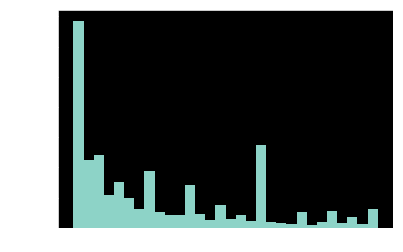

In [16]:
data = df_all['time']
plt.hist(data, bins= 30)

In [17]:
df_all['dayofweek'] = df_all['dayofweek'].astype( str )
df_all['mailType'] = df_all['mailType'].astype( str )


In [18]:
df_all = df_all.drop(['domain','recipientSn', 'campaignSn', 'mailAddress', 'fromMailAddress', 'scheduledDate'], axis = 1)

In [19]:
df_all

,openedFlag,domain_count,dayofweek,time,mailType,mailAddress_count,openSum
1,True,0.631987,5,2.414596,0,-0.055534,0.294342
2,False,0.631987,5,2.414596,0,-0.477082,0.294342
3,False,0.631987,5,2.414596,0,-0.701908,-0.387055
4,False,0.631987,5,2.414596,0,-0.252256,-0.500621
5,True,0.631987,5,2.414596,0,-0.701908,-0.387055
6,False,0.631987,5,2.414596,0,0.281705,-0.273489
9,False,0.631987,5,2.414596,0,-0.673805,-0.387055
10,False,0.631987,5,2.414596,0,-0.336566,-0.159923
11,True,0.631987,5,2.414596,0,0.000673,-0.500621
12,False,0.631987,5,2.414596,0,-0.589495,-0.387055


## One-Hot Encoding
要訓練非數值的feature 需要做One-Hot EncodingOne hot

In [20]:
df_all_dum = pd.get_dummies(df_all)


In [21]:
df_all_dum.head()

,openedFlag,domain_count,time,mailAddress_count,openSum,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,mailType_0,mailType_1,mailType_2,mailType_3,mailType_4,mailType_5,mailType_6,mailType_7
1,True,0.631987,2.414596,-0.055534,0.294342,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,False,0.631987,2.414596,-0.477082,0.294342,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,False,0.631987,2.414596,-0.701908,-0.387055,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,False,0.631987,2.414596,-0.252256,-0.500621,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
5,True,0.631987,2.414596,-0.701908,-0.387055,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


## 讀存檔

In [22]:
## save data as pickle format
with open('data/pickle/' + 'df_all_dum' + '.p', "wb") as file:
    pickle.dump(df_all_dum, file)

In [ ]:
## load 'df_all_dum'
with open('data/pickle/' + 'df_all_dum' + '.p', "rb") as file:
    df_all_dum = pickle.load(file)

## Training 開始
資料分割


In [23]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

print("df_all_dum = ", df_all_dum.shape)
print("df_train = ",trainCount)

#將train的部分取出(因為前面有先將train和test的資料和並)
X = df_all_dum[:trainCount]
X = X.drop(['openedFlag'], axis = 1)
y = df_all_dum['openedFlag']
y = y[:trainCount]
print("X = ",X.shape)

#切分為trainData和ValData
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 77, stratify=y)

#將後半剩下的test資料取出
y_test = df_all_dum[ trainCount : ]
y_test = y_test[ 'openedFlag' ]
X_test = df_all_dum[ trainCount : ]
X_test = X_test.drop(['openedFlag'], axis = 1)

print("X_test = ",X_test.shape)


df_all_dum =  (14335246, 20)
df_train =  10836556
X =  (10836556, 19)
X_test =  (3498690, 19)


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [25]:
clf = RandomForestClassifier(verbose = 1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [26]:
with open('data/pickle/RandomForestModel', "wb") as file:
    pickle.dump(clf, file)

In [44]:

threshold_RF = 0.1

y_pred_proba_RF = clf.predict_proba(X_val)
y_pred_RF = (y_pred_proba_RF [:,1] >= threshold_RF).astype('int')

print('acc ' + str(accuracy_score(y_val, y_pred_RF)))
print("recall = " + str(recall_score(y_val, y_pred_RF)))
print('f1_score ' + str(f1_score(y_val, y_pred_RF)))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.2s finished


acc 0.6030040898587744
recall = 0.9156156706796472
f1_score 0.5977001390539655


In [28]:
def errorCount(y_pred, y_val):
    errorCount = 0
    missCount = 0
    for i in range(y_val.shape[0]):
        if y_val.data[i] != y_pred.data[i] and y_pred.data[i] == 1:
            errorCount = errorCount + 1
        if y_val.data[i] != y_pred.data[i] and y_pred.data[i] == 0:
            missCount = missCount + 1
    print('error count : ' + str(errorCount))
    print('miss count : ' + str(missCount))

In [29]:
errorCount(y_pred_RF, y_val)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.data is deprecated and will be removed in a future version
  import sys


error count : 25487
miss count : 226142


In [30]:
y_test_proba = clf.predict_proba(X_test)
y_ans_pred = (y_test_proba [:,1] >= threshold_RF).astype('int')

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.6s finished


In [31]:
print('acc ' + str(accuracy_score(y_test, y_ans_pred)))
print("recall = " + str(recall_score(y_test, y_ans_pred)))
print('f1_score ' + str(f1_score(y_test, y_ans_pred)))

acc 0.7485647485201604
recall = 0.25218975986625
f1_score 0.3605313506786541


acc 0.749054360346301<br>
recall = 0.25923827983976844<br>
f1_score 0.36736361455037525<br>

### lightGBM

In [33]:
import lightgbm as lgb
pos_weight = 5
lgbm = lgb.LGBMClassifier(objective = 'binary', scale_pos_weight=pos_weight)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=5, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [34]:
with open('data/pickle/LightGBMModel', "wb") as file:
    pickle.dump(lgbm, file)

In [43]:
threshold_GBM = 0.1

y_pred_proba_GBM = lgbm.predict_proba(X_val)
y_pred_GBM = (y_pred_proba_GBM [:,1] >= threshold_GBM).astype('int')
print("acc = " + str(accuracy_score(y_val, y_pred_GBM)))
print("recall = " + str(recall_score(y_val, y_pred_GBM)))
print("f1 = " + str(f1_score(y_val, y_pred_GBM)))

acc = 0.36168119772326274
recall = 0.9986820768177312
f1 = 0.501954832215635


In [36]:
errorCount(y_pred_GBM, y_val)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.data is deprecated and will be removed in a future version
  import sys


error count : 347865
miss count : 33268


In [37]:
sendRate = y_pred_GBM.sum() / X_val.shape[0]
print(sendRate)
print( y_pred_GBM.sum())
print(X_val.shape[0])

0.6124000605358157
663631
1083656


In [38]:
 y_pred_GBM.sum()

663631

In [45]:
threshold_GBM = 0.1

y_pred_proba_GBM = lgbm.predict_proba(X_test)
y_pred_GBM = (y_pred_proba_GBM [:,1] >= threshold_GBM).astype('int')
print("acc = " + str(accuracy_score(y_test, y_pred_GBM)))
print("recall = " + str(recall_score(y_test, y_pred_GBM)))
print("f1 = " + str(f1_score(y_test, y_pred_GBM)))

acc = 0.3195776133352769
recall = 0.9964955706494381
f1 = 0.4515217555086008


In [40]:
sendRate = y_pred_GBM.sum() / y_test.shape[0]
print(sendRate)
print( y_pred_GBM.sum())
print(y_test.shape[0])

0.24266939911795557
849025
3498690


## Naive Bayes Classification


In [41]:
from sklearn.naive_bayes import GaussianNB
modelNB = GaussianNB()
modelNB.fit(X_train, y_train)

GaussianNB(priors=None)

In [46]:
threshold_NB = 0.1

y_pred_proba_NB = modelNB.predict_proba(X_val)
y_pred_NB = (y_pred_proba_NB [:,1] >= threshold_NB).astype('int')
print("acc = " + str(accuracy_score(y_val, y_pred_NB)))
print("recall = " + str(recall_score(y_val, y_pred_NB)))
print("f1 = " + str(f1_score(y_val, y_pred_NB)))

acc = 0.43495445048982334
recall = 0.9424067569348545
f1 = 0.5179301500024799
